In [1]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('C:\\Users\\IdeaPad S340\\OneDrive\\Desktop\\School\\CPEN316\\AirQualityUCI.csv', sep=';', decimal=',')  # Note: European decimal format
df = df.iloc[:, :-2]  # Drop last two empty columns if present

# Replace missing values (-200) with NaN
df.replace(-200, np.nan, inplace=True)

# Combine Date and Time into datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Drop high-null column: NMHC(GT) (~91% missing)
df.drop('NMHC(GT)', axis=1, inplace=True)

# Explore before cleaning
print("Shape before cleaning:", df.shape)
print(df.head())
print(df.describe())
print("Null values per column before interpolation:\n", df.isnull().sum())

Shape before cleaning: (9471, 12)
                     CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
Datetime                                                                     
2004-03-10 18:00:00     2.6       1360.0      11.9         1046.0    166.0   
2004-03-10 19:00:00     2.0       1292.0       9.4          955.0    103.0   
2004-03-10 20:00:00     2.2       1402.0       9.0          939.0    131.0   
2004-03-10 21:00:00     2.2       1376.0       9.2          948.0    172.0   
2004-03-10 22:00:00     1.6       1272.0       6.5          836.0    131.0   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T  \
Datetime                                                                      
2004-03-10 18:00:00        1056.0    113.0        1692.0       1268.0  13.6   
2004-03-10 19:00:00        1174.0     92.0        1559.0        972.0  13.3   
2004-03-10 20:00:00        1140.0    114.0        1555.0       1074.0  11.9   
2004-03-10 21:00:00     

In [2]:
import pandas as pd
import numpy as np


# Load data
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',')  # Note: European decimal format
df = df.iloc[:, :-2]  # Drop last two empty columns if present

# Replace missing values (-200) with NaN
df.replace(-200, np.nan, inplace=True)

# Combine Date and Time into datetime, handling potential parsing errors
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Drop rows where Datetime index failed to parse (if any)
df = df.dropna(how='all')  # Drop rows where all values are NaN (including index parse failures)

# Check for duplicate or NaN indices and handle them
if df.index.duplicated().any():
    df = df[~df.index.duplicated(keep='first')]  # Keep first occurrence, drop duplicates
if df.index.isnull().any():
    raise ValueError("NaNs found in index after parsing. Check Date/Time data.")

# Drop high-null column: NMHC(GT) (~91% missing)
df.drop('NMHC(GT)', axis=1, inplace=True)

# Interpolate missing values using linear method (safer initial step)
df.interpolate(method='linear', inplace=True)

# Fill any remaining edge nulls with forward/backward fill
df.ffill(inplace=True)  # Forward fill
df.bfill(inplace=True)  # Backward fill (in case of leading nulls)

# Drop any rows that still have nulls (should be none or very few)
df.dropna(inplace=True)

# Verify no nulls remain
print("Null values per column after handling:\n", df.isnull().sum())
print("Shape after cleaning:", df.shape)  # Check how many rows remain (~9357 expected, minor loss if any)

# Select target and features (exclude dropped NMHC(GT))
features = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)',
            'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
target = 'CO(GT)'
data = df[features + [target]]



Null values per column after handling:
 CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64
Shape after cleaning: (9326, 12)


In [3]:
from sklearn.preprocessing import MinMaxScaler

# Standardize
# Scale
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, index=data.index, columns=data.columns)

# Train-test split (chronological)
train_size = int(len(data_scaled) * 0.8)
train = data_scaled[:train_size]
test = data_scaled[train_size:]

In [4]:
# Create a time series sequence
def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)  # All columns as input
        y.append(data.iloc[i+seq_length][target])  # Predict target
    return np.array(X), np.array(y)

seq_length = 24
X_train_ts, y_train_ts = create_sequences(train, seq_length)  # Use distinct names
X_test_ts, y_test_ts = create_sequences(test, seq_length)
print("X_train_ts shape:", X_train_ts.shape)  # Debug: Should be 3D, e.g., (7458, 24, 12)
print("y_train_ts shape:", y_train_ts.shape)  # Debug: Should be 1D, e.g., (7458,)
print("X_test_ts shape:", X_test_ts.shape)    # Debug: Should be 3D, e.g., (1838, 24, 12)
print("y_test_ts shape:", y_test_ts.shape)    # Debug: Should be 1D, e.g., (1838,)

X_train_ts shape: (7436, 24, 12)
y_train_ts shape: (7436,)
X_test_ts shape: (1842, 24, 12)
y_test_ts shape: (1842,)


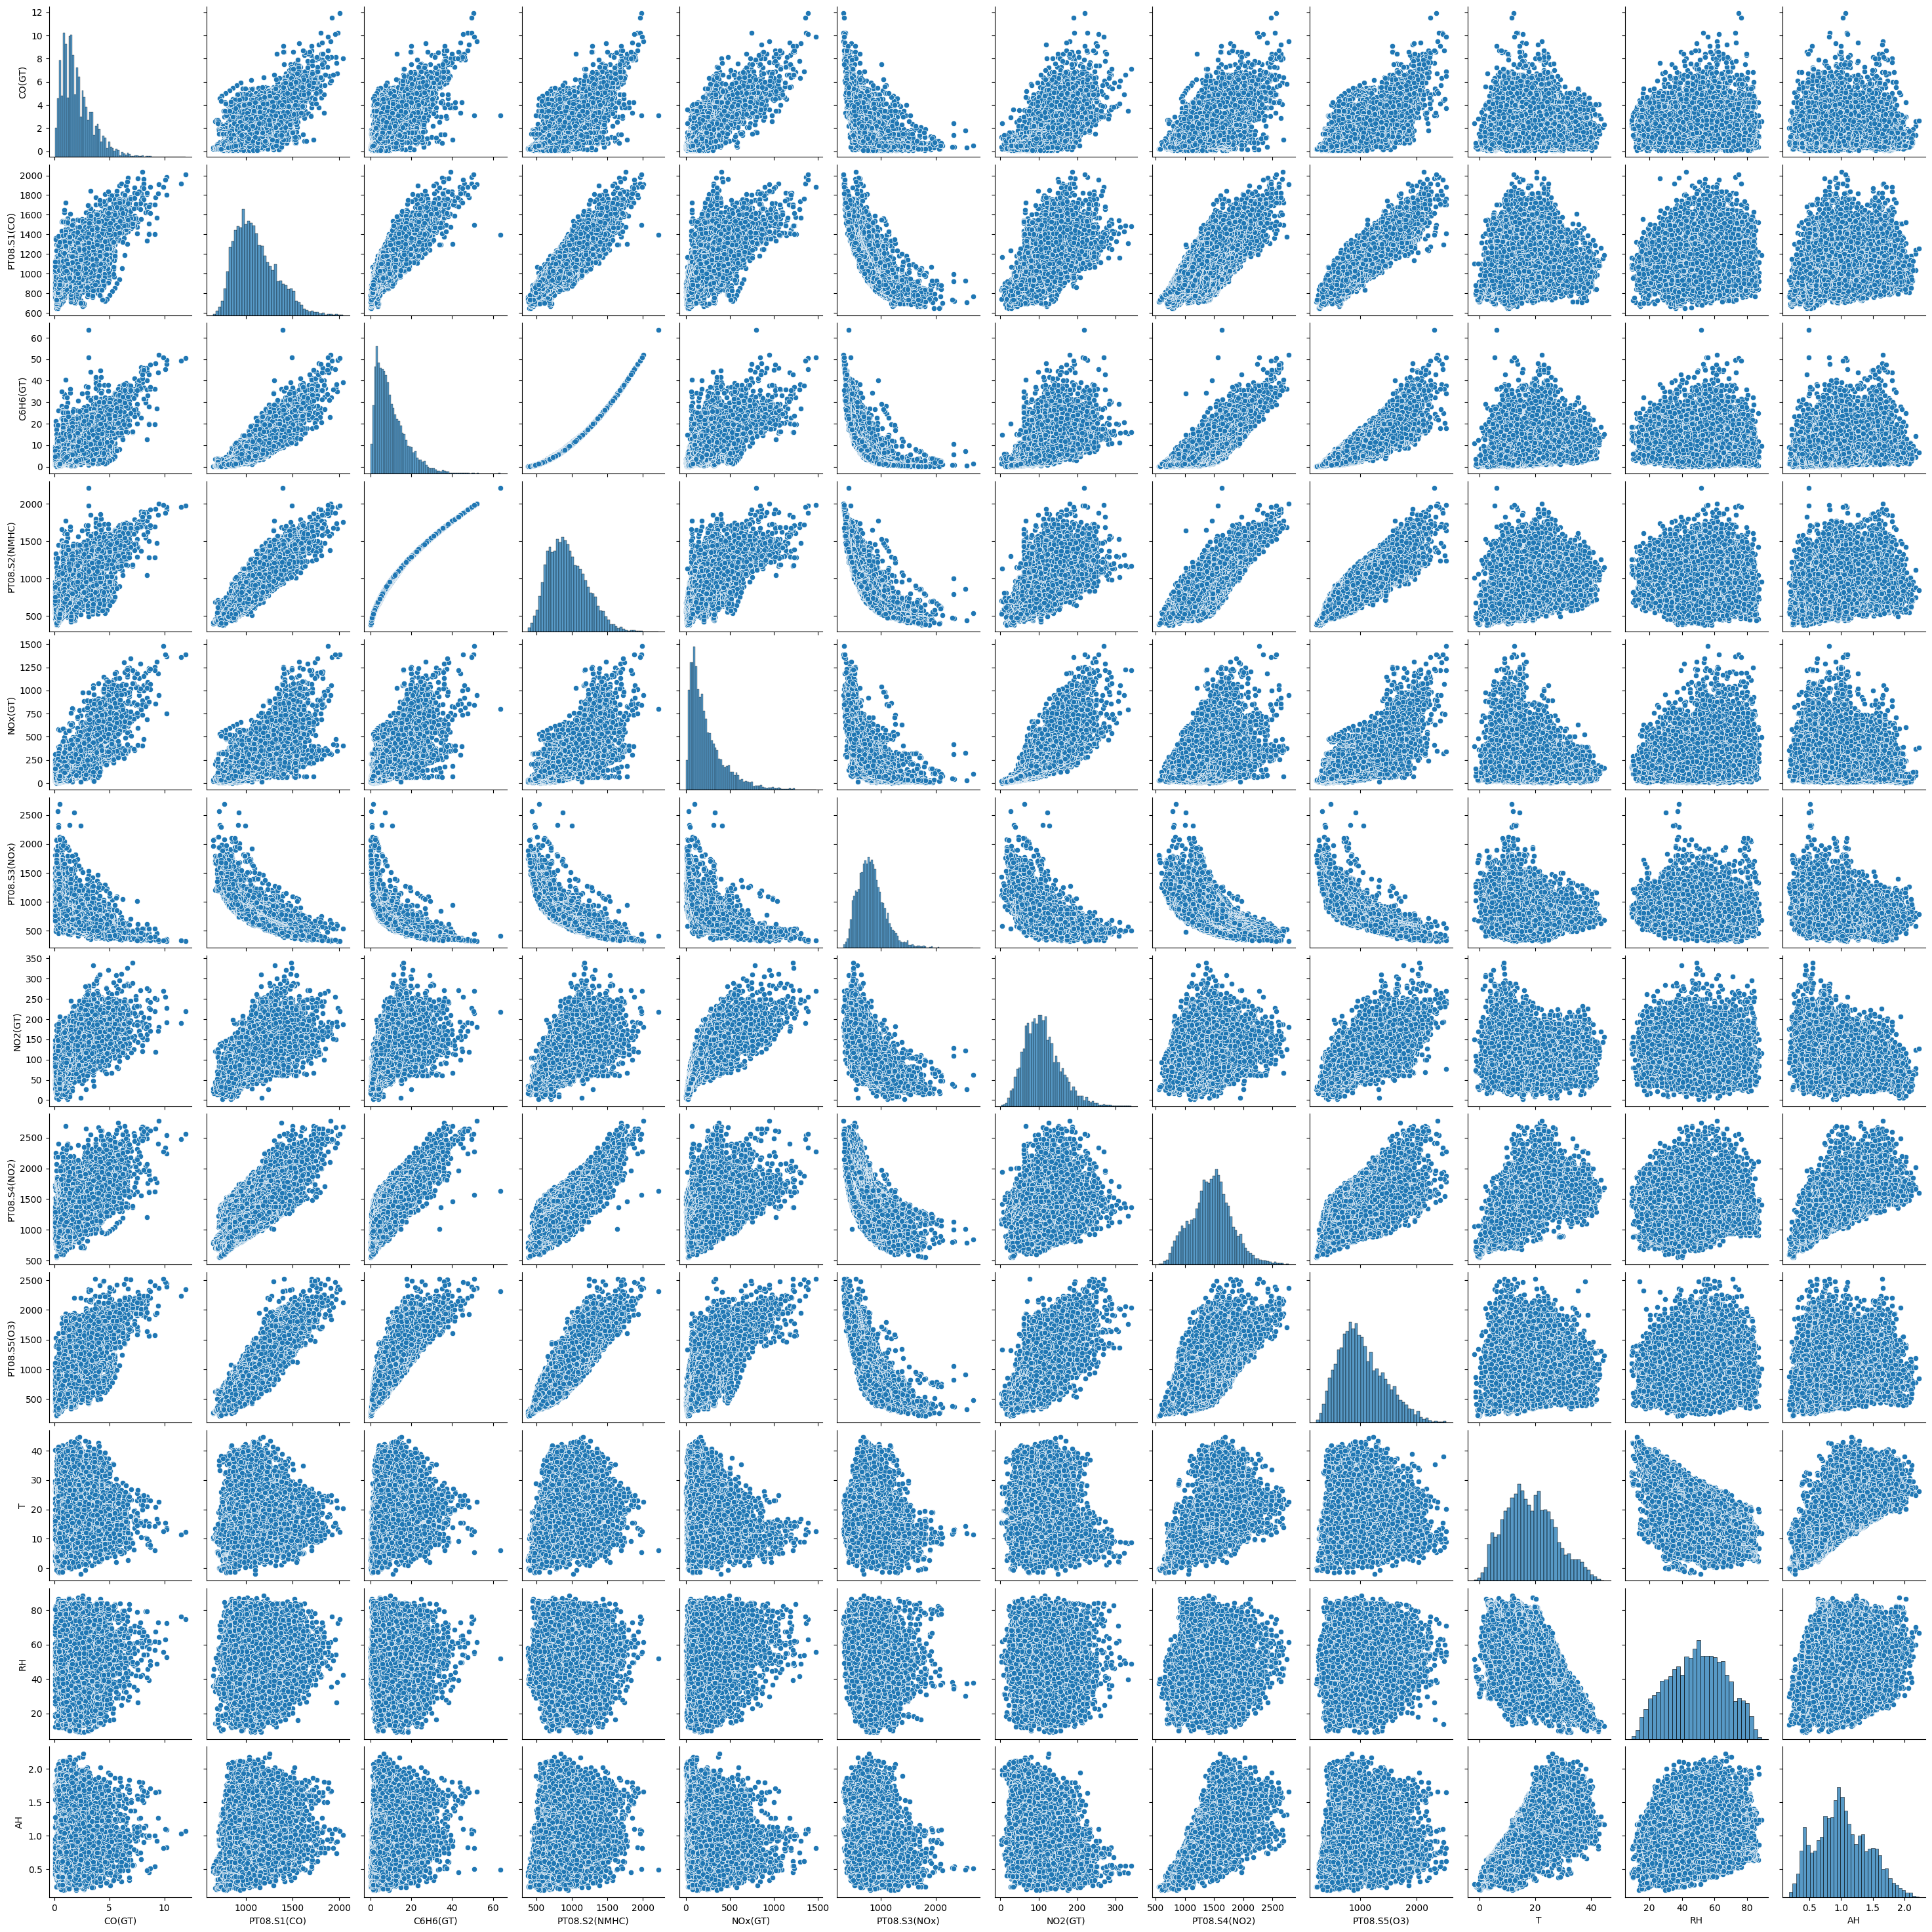

In [5]:
#DATA VISUALIZATION
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(data=df)

In [6]:
df.head()

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
Datetime                                                                     
2004-03-10 18:00:00     2.6       1360.0      11.9         1046.0    166.0   
2004-03-10 19:00:00     2.0       1292.0       9.4          955.0    103.0   
2004-03-10 20:00:00     2.2       1402.0       9.0          939.0    131.0   
2004-03-10 21:00:00     2.2       1376.0       9.2          948.0    172.0   
2004-03-10 22:00:00     1.6       1272.0       6.5          836.0    131.0   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T  \
Datetime                                                                      
2004-03-10 18:00:00        1056.0    113.0        1692.0       1268.0  13.6   
2004-03-10 19:00:00        1174.0     92.0        1559.0        972.0  13.3   
2004-03-10 20:00:00        1140.0    114.0        1555.0       1074.0  11.9   
2004-03-10 21:00:00        1092.0    122.0        1584.0       1203.0  11.0   
2004-03-10 22:00:00        1205.0    116.0        1490.0       1110.0  11.2   

                       RH      AH  
Datetime                           
2004-03-10 18:00:00  48.9  0.7578  
2004-03-10 19:00:00  47.7  0.7255  
2004-03-10 20:00:00  54.0  0.7502  
2004-03-10 21:00:00  60.0  0.7867  
2004-03-10 22:00:00  59.6  0.7888

# CALCULATE AIR QUALITY INDEX FOR CO(GT) BASED ON FORMULA
The air quality index is a piecewise linear function of the pollutant concentration. At the boundary between AQI categories, there is a discontinuous jump of one AQI unit. To convert from concentration to AQI this equation is used

Function to calculate co(GT) individual pollutant index(co)


Function to calculate CO(GT) individual pollutant index(COi)

In [7]:
import numpy as np

import numpy as np

# CO(GT) - Carbon Monoxide
def cal_COi(CO):
    if CO < 0:
        return np.nan
    if CO <= 1.0:
        return CO * (50 / 1.0)
    elif 1.0 < CO <= 2.0:
        return 50 + (CO - 1.0) * (50 / 1.0)
    elif 2.0 < CO <= 10.0:
        return 100 + (CO - 2.0) * (100 / 8.0)
    elif 10.0 < CO <= 17.0:
        return 200 + (CO - 10.0) * (100 / 7.0)
    elif 17.0 < CO <= 34.0:
        return 300 + (CO - 17.0) * (100 / 17.0)
    elif CO > 34.0:
        return 400 + (CO - 34.0) * (100 / 17.0)
    else:
        return np.nan

# Add the calculated COi column to the DataFrame df
df['COi'] = df['CO(GT)'].apply(cal_COi)

# Display the first few rows to verify
data = df[['CO(GT)', 'COi']] # Use the correct column names
data.head()
# calculating the individual pollutant index for C0

CO(GT)    COi
Datetime                          
2004-03-10 18:00:00     2.6  107.5
2004-03-10 19:00:00     2.0  100.0
2004-03-10 20:00:00     2.2  102.5
2004-03-10 21:00:00     2.2  102.5
2004-03-10 22:00:00     1.6   80.0

Function to calculate C6H6(GT)  individual pollutant index

In [8]:
# Define the function to calculate C6H6 individual pollutant index
def cal_C6H6i(C6H6):
    if C6H6 < 0:
        return np.nan
    if C6H6 <= 5:
        C6H6_index = C6H6 * (50 / 5)
    elif 5 < C6H6 <= 10:
        C6H6_index = 50 + (C6H6 - 5) * (50 / 5)
    elif 10 < C6H6 <= 15:
        C6H6_index = 100 + (C6H6 - 10) * (100 / 5)
    elif 15 < C6H6 <= 20:
        C6H6_index = 200 + (C6H6 - 15) * (100 / 5)
    elif 20 < C6H6 <= 25:
        C6H6_index = 300 + (C6H6 - 20) * (100 / 5)
    elif C6H6 > 25:
        C6H6_index = 400 + (C6H6 - 25) * (100 / 5)
    else:
        C6H6_index = np.nan
    return C6H6_index

# Add the calculated C6H6i column to the DataFrame df
df['C6H6i'] = df['C6H6(GT)'].apply(cal_C6H6i)

# Create a subset DataFrame with the original and calculated index columns
data = df[['C6H6(GT)', 'C6H6i']]  # Use the correct column names

# Display the first few rows to verify
data.head()

C6H6(GT)  C6H6i
Datetime                            
2004-03-10 18:00:00      11.9  138.0
2004-03-10 19:00:00       9.4   94.0
2004-03-10 20:00:00       9.0   90.0
2004-03-10 21:00:00       9.2   92.0
2004-03-10 22:00:00       6.5   65.0

Function to calculate NOx(GT)individual pollutant index

In [9]:
def cal_NOxi(NOx):
    if NOx < 0:
        return np.nan
    if NOx <= 40:
        NOx_index = NOx * (50 / 40)
    elif 40 < NOx <= 80:
        NOx_index = 50 + (NOx - 40) * (50 / 40)
    elif 80 < NOx <= 180:
        NOx_index = 100 + (NOx - 80) * (100 / 100)
    elif 180 < NOx <= 280:
        NOx_index = 200 + (NOx - 180) * (100 / 100)
    elif 280 < NOx <= 400:
        NOx_index = 300 + (NOx - 280) * (100 / 120)
    elif NOx > 400:
        NOx_index = 400 + (NOx - 400) * (100 / 120)
    else:
        NOx_index = np.nan
    return NOx_index

# Add the calculated NOxi column to the DataFrame df
df['NOxi'] = df['NOx(GT)'].apply(cal_NOxi)

# Create a subset DataFrame with the original and calculated index columns
data = df[['NOx(GT)', 'NOxi']]  # Use the correct column names

# Display the first few rows to verify
data.head()

NOx(GT)   NOxi
Datetime                           
2004-03-10 18:00:00    166.0  186.0
2004-03-10 19:00:00    103.0  123.0
2004-03-10 20:00:00    131.0  151.0
2004-03-10 21:00:00    172.0  192.0
2004-03-10 22:00:00    131.0  151.0

Function to calculate NOx(GT)individual pollutant index

In [10]:
def cal_NO2i(NO2):
    if NO2 < 0:
        return np.nan
    if NO2 <= 40:
        NO2_index = NO2 * (50 / 40)
    elif 40 < NO2 <= 80:
        NO2_index = 50 + (NO2 - 40) * (50 / 40)
    elif 80 < NO2 <= 180:
        NO2_index = 100 + (NO2 - 80) * (100 / 100)
    elif 180 < NO2 <= 280:
        NO2_index = 200 + (NO2 - 180) * (100 / 100)
    elif 280 < NO2 <= 400:
        NO2_index = 300 + (NO2 - 280) * (100 / 120)
    elif NO2 > 400:
        NO2_index = 400 + (NO2 - 400) * (100 / 120)
    else:
        NO2_index = np.nan
    return NO2_index

# Add the calculated NO2i column to the DataFrame df
df['NO2i'] = df['NO2(GT)'].apply(cal_NO2i)

# Create a subset DataFrame with the original and calculated index columns
data = df[['NO2(GT)', 'NO2i']]  # Use the correct column names

# Display the first few rows to verify
data.head()

NO2(GT)   NO2i
Datetime                           
2004-03-10 18:00:00    113.0  133.0
2004-03-10 19:00:00     92.0  112.0
2004-03-10 20:00:00    114.0  134.0
2004-03-10 21:00:00    122.0  142.0
2004-03-10 22:00:00    116.0  136.0

In [11]:
def cal_aqi(COi,C6H6i,NOxi,NO2i):
    aqi=0
    if(COi>C6H6i and COi>NOxi and COi>NO2i ):
     aqi=COi
    if(C6H6i>COi and C6H6i>NOxi and C6H6i>NO2i ):
     aqi=C6H6i
    if(NOxi>COi and NOxi>C6H6i and NOxi>NO2i ):
     aqi=NOxi
    if(NO2i>COi and NO2i>C6H6i and NO2i>NOxi ):
     aqi=NO2i


    return aqi

df['AQI']=df.apply(lambda x:cal_aqi(x['COi'],x['C6H6i'],x['NOxi'],x['NO2i']),axis=1)
data= df[['COi','C6H6i','NOxi','NO2i','AQI']] # Fix: use double brackets to select multiple columns
data.head()
# Caluclating the Air Quality Index.

COi  C6H6i   NOxi   NO2i    AQI
Datetime                                              
2004-03-10 18:00:00  107.5  138.0  186.0  133.0  186.0
2004-03-10 19:00:00  100.0   94.0  123.0  112.0  123.0
2004-03-10 20:00:00  102.5   90.0  151.0  134.0  151.0
2004-03-10 21:00:00  102.5   92.0  192.0  142.0  192.0
2004-03-10 22:00:00   80.0   65.0  151.0  136.0  151.0

In [12]:
# Using threshold values to classify a particular values as good, moderate, poor, unhealthy, very unhealthy and Hazardous
# Define the function to classify AQI into ranges
def AQI_Range(x):
    if x <= 50:
        return "Good"
    elif x > 50 and x <= 100:
        return "Moderate"
    elif x > 100 and x <= 200:
        return "Poor"
    elif x > 200 and x <= 300:
        return "Unhealthy"
    elif x > 300 and x <= 400:
        return "Very Unhealthy"
    elif x > 400:
        return "Hazardous"

# Apply the function to the 'AQI' column in the DataFrame
df['AQI_Range'] = df['AQI'].apply(AQI_Range)
df.head()



CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
Datetime                                                                     
2004-03-10 18:00:00     2.6       1360.0      11.9         1046.0    166.0   
2004-03-10 19:00:00     2.0       1292.0       9.4          955.0    103.0   
2004-03-10 20:00:00     2.2       1402.0       9.0          939.0    131.0   
2004-03-10 21:00:00     2.2       1376.0       9.2          948.0    172.0   
2004-03-10 22:00:00     1.6       1272.0       6.5          836.0    131.0   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T  \
Datetime                                                                      
2004-03-10 18:00:00        1056.0    113.0        1692.0       1268.0  13.6   
2004-03-10 19:00:00        1174.0     92.0        1559.0        972.0  13.3   
2004-03-10 20:00:00        1140.0    114.0        1555.0       1074.0  11.9   
2004-03-10 21:00:00        1092.0    122.0        1584.0       1203.0  11.0   
2004-03-10 22:00:00        1205.0    116.0        1490.0       1110.0  11.2   

                       RH      AH    COi  C6H6i   NOxi   NO2i    AQI AQI_Range  
Datetime                                                                        
2004-03-10 18:00:00  48.9  0.7578  107.5  138.0  186.0  133.0  186.0      Poor  
2004-03-10 19:00:00  47.7  0.7255  100.0   94.0  123.0  112.0  123.0      Poor  
2004-03-10 20:00:00  54.0  0.7502  102.5   90.0  151.0  134.0  151.0      Poor  
2004-03-10 21:00:00  60.0  0.7867  102.5   92.0  192.0  142.0  192.0      Poor  
2004-03-10 22:00:00  59.6  0.7888   80.0   65.0  151.0  136.0  151.0      Poor

In [13]:
df['AQI_Range'].value_counts()
# These are the counts of values present in the AQI_Range column.

AQI_Range
Poor              2856
Hazardous         1790
Unhealthy         1734
Very Unhealthy    1314
Moderate          1268
Good               364
Name: count, dtype: int64

Splitting the dataset into Dependent and Independent columns


In [14]:
X=df[['COi','C6H6i','NOxi','NO2i']]
Y=df['AQI']
X.head()
# we only select columns like COi,C6H6i,NOxi,NO2i

COi  C6H6i   NOxi   NO2i
Datetime                                       
2004-03-10 18:00:00  107.5  138.0  186.0  133.0
2004-03-10 19:00:00  100.0   94.0  123.0  112.0
2004-03-10 20:00:00  102.5   90.0  151.0  134.0
2004-03-10 21:00:00  102.5   92.0  192.0  142.0
2004-03-10 22:00:00   80.0   65.0  151.0  136.0

In [15]:
Y.head()
# the AQI column is the target column

Datetime
2004-03-10 18:00:00    186.0
2004-03-10 19:00:00    123.0
2004-03-10 20:00:00    151.0
2004-03-10 21:00:00    192.0
2004-03-10 22:00:00    151.0
Name: AQI, dtype: float64

In [16]:
#Splitting data into training and testing data
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(7460, 4) (1866, 4) (7460,) (1866,)


In [17]:
print("X_train shape:", X_train.shape)

X_train shape: (7460, 4)


### LTSM

In [31]:
#Implementing LTSM from Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

print("X_train_ts shape:", X_train_ts.shape)  # Should show (7436, 24, 12)
model = Sequential([
    Input(shape=(seq_length, X_train_ts.shape[2])),  # Explicit Input layer
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Regression output
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()  # Confirm model architecture

X_train_ts shape: (7436, 24, 12)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,825 (85.25 KB)

 Trainable params: 21,825 (85.25 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_ts, y_train_ts,    # Use 3D time series training data
    validation_split=0.1,      # Use 10% of training data as validation set
    epochs=50,                 # Maximum of 50 training passes (epochs)
    batch_size=32,             # Update model weights after every 32 samples
    callbacks=[early_stop],    # Apply early stopping during training
    verbose=1                  # Show training progress
)

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 0.0108 - mae: 0.0756 - val_loss: 0.0057 - val_mae: 0.0576
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0058 - mae: 0.0553 - val_loss: 0.0046 - val_mae: 0.0541
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0044 - mae: 0.0478 - val_loss: 0.0036 - val_mae: 0.0454
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0037 - mae: 0.0436 - val_loss: 0.0034 - val_mae: 0.0428
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0036 - mae: 0.0426 - val_loss: 0.0036 - val_mae: 0.0454
Epoch 6/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 0.0034 - mae: 0.0414 - val_loss: 0.0032 - val_mae: 0.0413
Epoch 7/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0032 - mae: 0.0403 - val_loss: 0.0037 - val_mae: 0.0465
Epoch 8/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 0.0032 - mae: 0.0402 - val_loss: 0.0032 - val_mae: 0.0426
Epoch 9/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 10s 

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


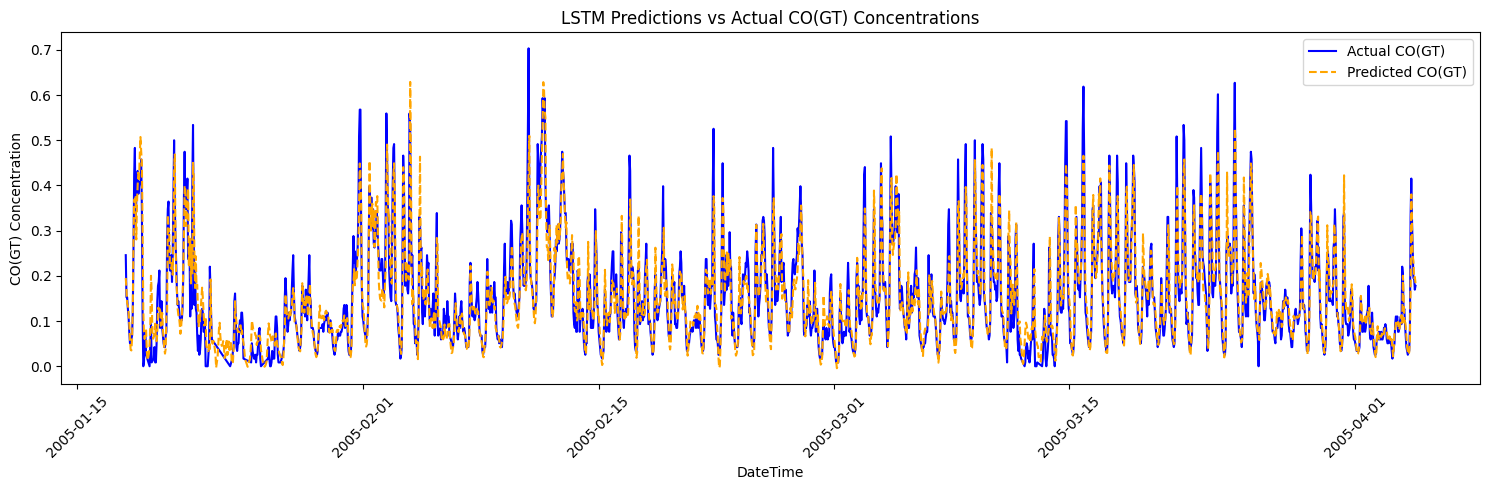

In [33]:
# Visualization
import matplotlib.pyplot as plt
import pandas as pd

# Predict on test data
y_pred = model.predict(X_test_ts)

# Ensure y_pred is 1D for plotting
y_pred = y_pred.flatten()

# Get time index for test data (align with y_test_ts)
test_index = test.index[seq_length:]  # Skip first seq_length rows due to sequence creation

plt.figure(figsize=(15, 5))
plt.plot(test_index, y_test_ts, label='Actual CO(GT)', color='blue')
plt.plot(test_index, y_pred, label='Predicted CO(GT)', color='orange', linestyle='--')
plt.title('LSTM Predictions vs Actual CO(GT) Concentrations')
plt.xlabel('DateTime')
plt.ylabel('CO(GT) Concentration')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Linear Regression


In [19]:
#Linear Regression
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train,Y_train)

LinearRegression()

In [20]:
#predicting train
train_pred=model.predict(X_train)
#predicting on test
test_pred=model.predict(X_test)

In [21]:
#Evaluation metrics
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
RMSE_train=(np.sqrt(metrics.mean_squared_error(Y_train,train_pred)))
RMSE_test=(np.sqrt(metrics.mean_squared_error(Y_test,test_pred)))
print("RMSE TrainingData = ",str(RMSE_train))
print("RMSE TestData = ",str(RMSE_test))
print('-'*50)
print('RSquared value on train:',model.score(X_train, Y_train))
print('RSquared value on test:',model.score(X_test, Y_test))

RMSE TrainingData =  28.949781017112027
RMSE TestData =  27.192959058069942
--------------------------------------------------
RSquared value on train: 0.9754466596427308
RSquared value on test: 0.9792933818750392


### Random Forest Classifier

In [22]:
#fit the model on train data
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
RF=RandomForestRegressor(random_state=42).fit(X_train,Y_train)
#predict on train
train_preds4 = RF.predict(X_train)
#evaluate train
print("RMSE TrainingData = ",str(np.sqrt(mean_squared_error(Y_train,train_preds4))))
print('RSquared value on train:',r2_score(Y_train,train_preds4))
print('-'*50)

#predict on test
test_preds4 = RF.predict(X_test)
#evaluate on test
print("RMSE TestData = ",str(np.sqrt(mean_squared_error(Y_test,test_preds4))))
print('RSquared value on test:',r2_score(Y_test,test_preds4))

RMSE TrainingData =  4.7830640237419
RSquared value on train: 0.999329756815573
--------------------------------------------------
RMSE TestData =  11.447617016234476
RSquared value on test: 0.9963303350006734


### Classification Algorithms

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
X2 = df[['COi','C6H6i','NOxi','NO2i']]
Y2 = df['AQI_Range']
# Splitting the data into independent and dependent columns for classification

In [24]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.33, random_state=70)
# Splitting the data into training and testing data

Logistic Regression

In [25]:
#fit the model on train data
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, mean_absolute_error,mean_squared_error,r2_score, cohen_kappa_score
import numpy as np

#fit the model on train data
log_reg = LogisticRegression().fit(X_train2, Y_train2)

#predict on train
train_preds2 = log_reg.predict(X_train2)
#accuracy on train
print("Model accuracy on train is: ", accuracy_score(Y_train2, train_preds2))

#predict on test
test_preds2 = log_reg.predict(X_test2)
#accuracy on test
print("Model accuracy on test is: ", accuracy_score(Y_test2, test_preds2))
print('-'*50)

# Kappa Score.
print('KappaScore is: ', metrics.cohen_kappa_score(Y_test2,test_preds2))

Model accuracy on train is:  0.6137964148527529
Model accuracy on test is:  0.6130604288499025
--------------------------------------------------
KappaScore is:  0.5052027368745841


In [26]:
log_reg.predict([[1, 1.2, 3.12, 0]]) # Added 2 placeholder features (0, 1)

array(['Hazardous'], dtype=object)

K-Nearest Neighbours

In [27]:
#fit the model on train data
KNN = KNeighborsClassifier().fit(X_train2,Y_train2)
#predict on train
train_preds5 = KNN.predict(X_train2)
#accuracy on train
print("Model accuracy on train is: ", accuracy_score(Y_train2, train_preds5))

#predict on test
test_preds5 = KNN.predict(X_test2)
#accuracy on test
print("Model accuracy on test is: ", accuracy_score(Y_test2, test_preds5))
print('-'*50)

# Kappa Score
print('KappaScore is: ', metrics.cohen_kappa_score(Y_test2,test_preds5))

Model accuracy on train is:  0.9734314980793854
Model accuracy on test is:  0.9616634178037686
--------------------------------------------------
KappaScore is:  0.9518711220371648


In [28]:
KNN.predict([[7.4,47.7,78.182,100]])
# Predictions on random values

array(['Moderate'], dtype=object)

In [29]:
KNN.predict([[1,1.2,3.12,0]])
# Predictions on random values

array(['Good'], dtype=object)

In [30]:
KNN.predict([[325.7,345,798.182,305]])
# Predictions on random values

array(['Hazardous'], dtype=object)